In [2]:
import sys
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import numpy as np
#from scipy.stats import norm
#from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy import stats
%matplotlib inline
import random
import datetime
from sklearn import cluster
import calendar
import numbers

### only the EDA part is discussed here in detail.
also the procedure of how I went thorugh of doing all the load and transform jobs

In [3]:
df_train = pd.read_csv('../train.csv')
df_store = pd.read_csv('../store.csv')

c:\users\gebruiker\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_train['MonthYear'] = df_train['Date'].apply(lambda x : (str(x)[:7]))
df_train['Month'] = df_train['Date'].apply(lambda x : (str(x)[5:7]))
df_train['Year'] = df_train['Date'].apply(lambda x : (str(x)[:4]))
df_train['DayOfWeek_str'] = df_train['DayOfWeek'].apply(lambda x : (calendar.day_abbr[x-1]))
#df_train['salesPerCustomer'] = df_train['Sales']/df_train['Customers']

Lets look for issues with the data first. it is very indicative that the stores that are not open on any given day should not have made any sales. let us check that out.

In [5]:
print('Sales made by stores when closed: ',np.sum(df_train[df_train['Open'] == 0]['Sales']))

Sales made by stores when closed:  0


We shall remove these enteries from the table. Another cleaning is in order herenow. The stateHoliday has ambigous data tpye. lets all replace all of the confusing choices to one same choice 

In [6]:
df_train.StateHoliday.replace(["O",0,"0"],['O','O','O'], inplace=True)

some helpful functions

In [9]:
def getXticks(tempSeries,axis=0):
    if axis == 0:#to set the xticks of the multiple plots that will be draw in EDA part
        myxLabels = tempSeries.index.tolist()
        myxLabels.insert(0, ' ')   #basically you need an empty space to give spaings at the ends of your graph i.e. insert ...
        myxLabels.append(' ')      #and append
    else:
        myxLabels = tempSeries.columns.tolist()
        myxLabels.insert(0, ' ')   #basically you need an empty space to give spaings at the ends of your graph i.e. insert ...
        myxLabels.append(' ')      #and append
    return myxLabels

def seriesPlots(tempSeries  ,_title = "", _rot = 15):   #one function to plot a series
    plt.figure()
    axis = plt.gca()
    ax1 = tempSeries.plot(legend=True, ax=axis, marker='o', rot=_rot, figsize=(20, 12), title=_title)
    if(isinstance(tempSeries.index.tolist()[0],numbers.Number)): #the value of xlim are tricky to handle....
        minPoint = int(min(tempSeries.index.tolist())) - 1  #when they are int or float, we want the limits to be the min...
        maxPoint = int(max(tempSeries.index.tolist())) + 1  #max
    else:
        minPoint = -1                             #else an index like array from -1 to lenght of unique values works fine!!!
        maxPoint = len(tempSeries.index.tolist())
    ax1.set_xticks(range(minPoint, maxPoint + 1, 1))
    ax1.set_xticklabels(getXticks(tempSeries))
    ax1.set_ylabel("Sales")  ##DO CHANGE THIS
    #ax1.set_xlabel("Sales")  ##DO CHANGE THIS
    plt.show()

The sales vary interestingly over every month. It will always increase from the 5 to 6th motnh every year and also for the ending months of the data.

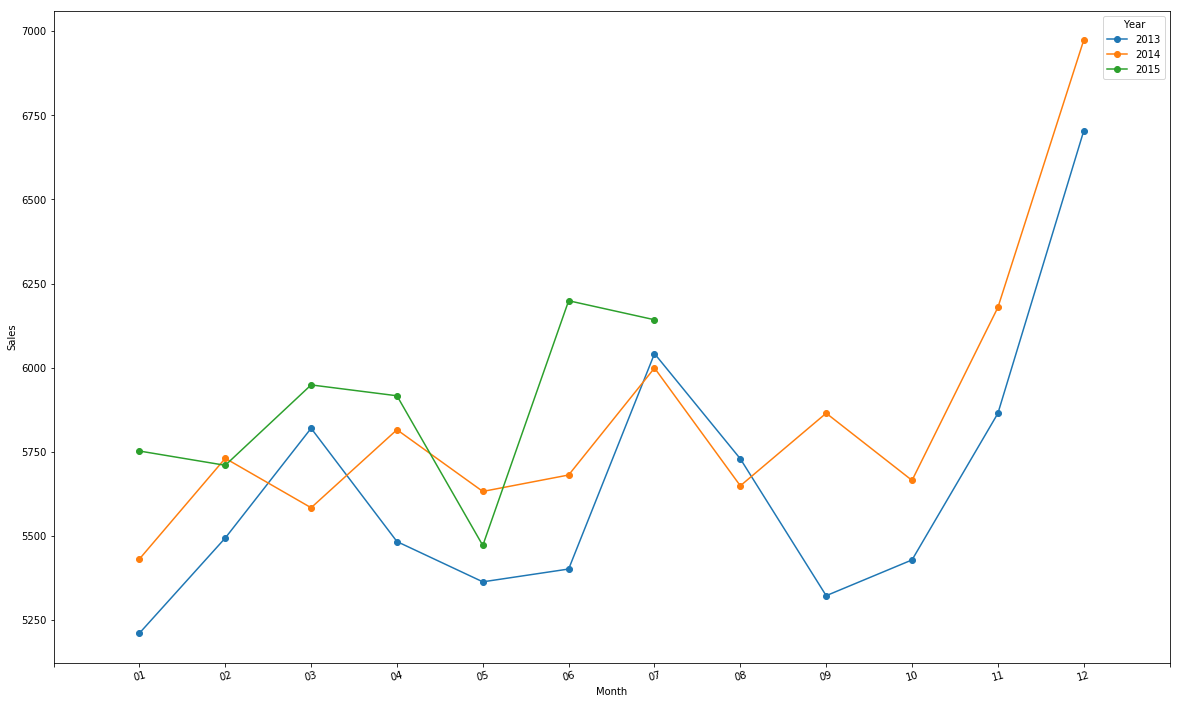

In [10]:
##this
overAllMonthlySales = df_train.groupby(['Month','Year'])["Sales"].mean()
seriesPlots(overAllMonthlySales.unstack())

Sales by weekdays varys very much the same. some months exhibit faster growth than other every year.

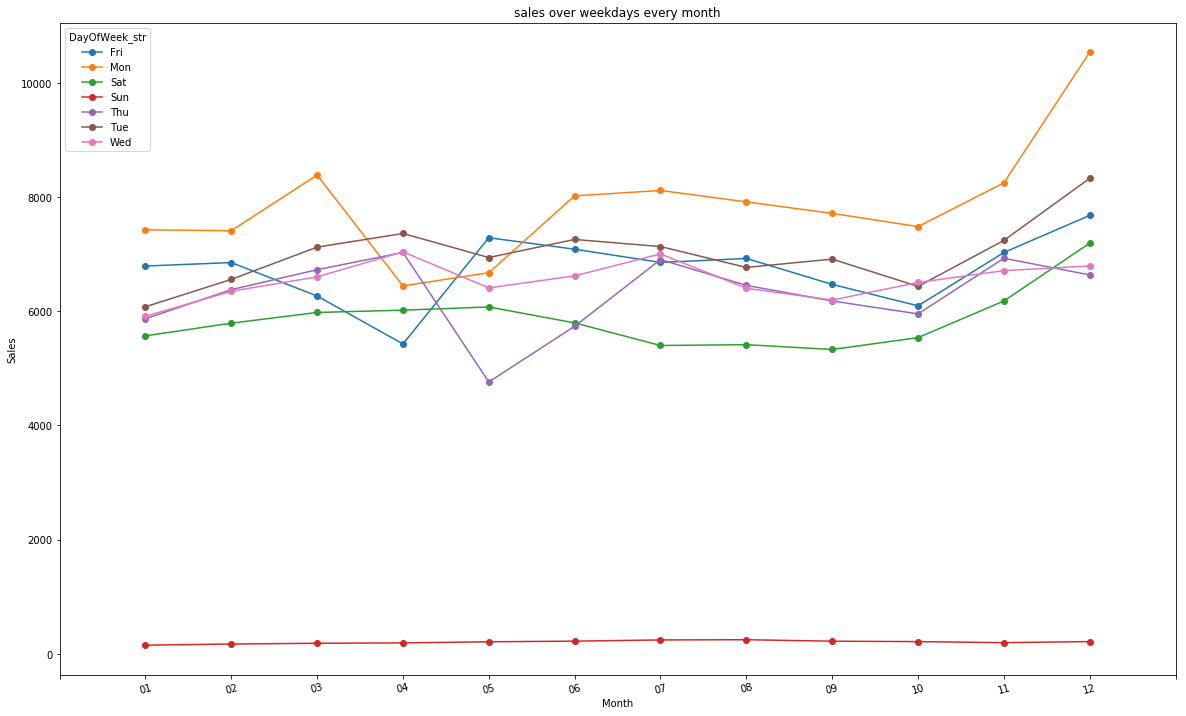

In [12]:
##this
monthlySalesOverWeekdays = df_train.groupby(['Month','DayOfWeek_str'])["Sales"].mean()
seriesPlots(monthlySalesOverWeekdays.unstack(),'sales over weekdays every month')

checking the value in the plot randomly to see if they are right

In [13]:
print(len(np.unique(df_train[df_train['DayOfWeek'] == 7]['Store'])))
print(np.mean(df_train[df_train['DayOfWeek'] == 7]['Customers']))
print(np.mean(df_train[df_train['DayOfWeek'] == 7]['Sales']))

print(len(np.unique(df_train[df_train['DayOfWeek'] == 4]['Store'])))
print(np.mean(df_train[df_train['DayOfWeek'] == 2]['Customers']))
print(np.mean(df_train[df_train['DayOfWeek'] == 1]['Sales']))

1115
35.78681683134112
204.18318938713466
1115
760.9846152789983
7809.044510467767


the customer plot over weekdays also exhibits same charecteristics. we will see so why

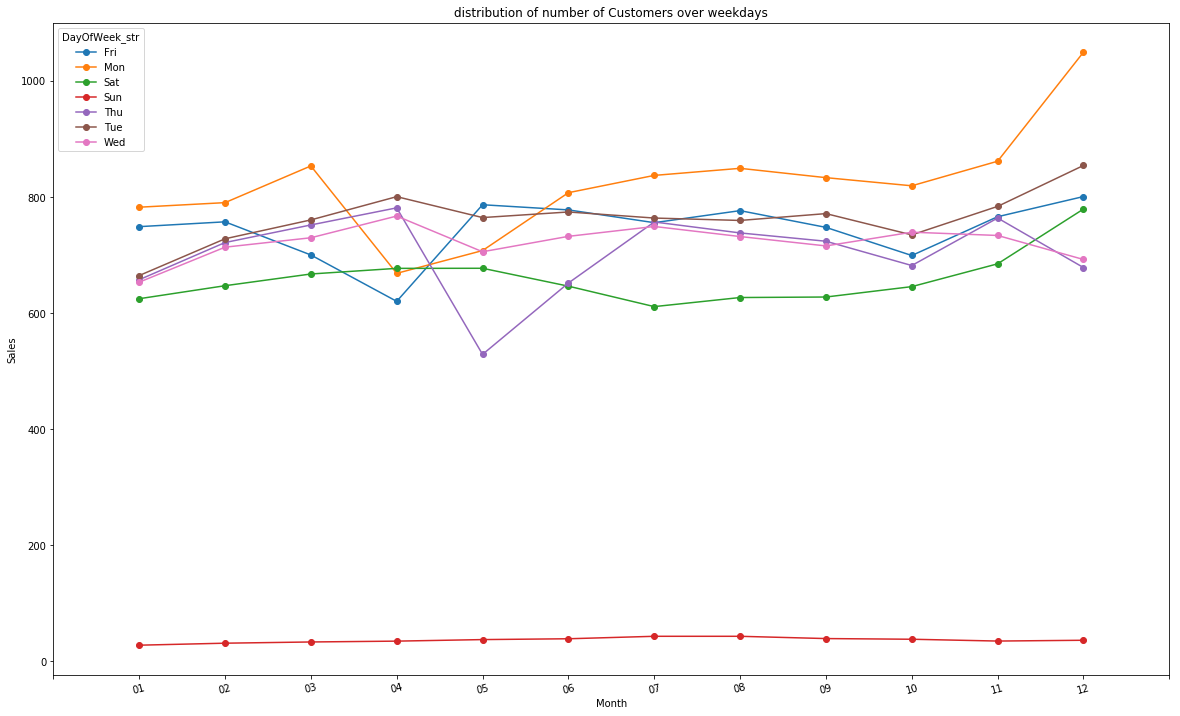

In [14]:
monthlyCustomersOverWeekdays = df_train.groupby(['Month','DayOfWeek_str'])["Customers"].mean()
seriesPlots(monthlyCustomersOverWeekdays.unstack(),'distribution of number of Customers over weekdays')
#_______________________________


Cusotmers also tend to come more in some particular months of every year. the fastBusiness months could be a feature on its own.

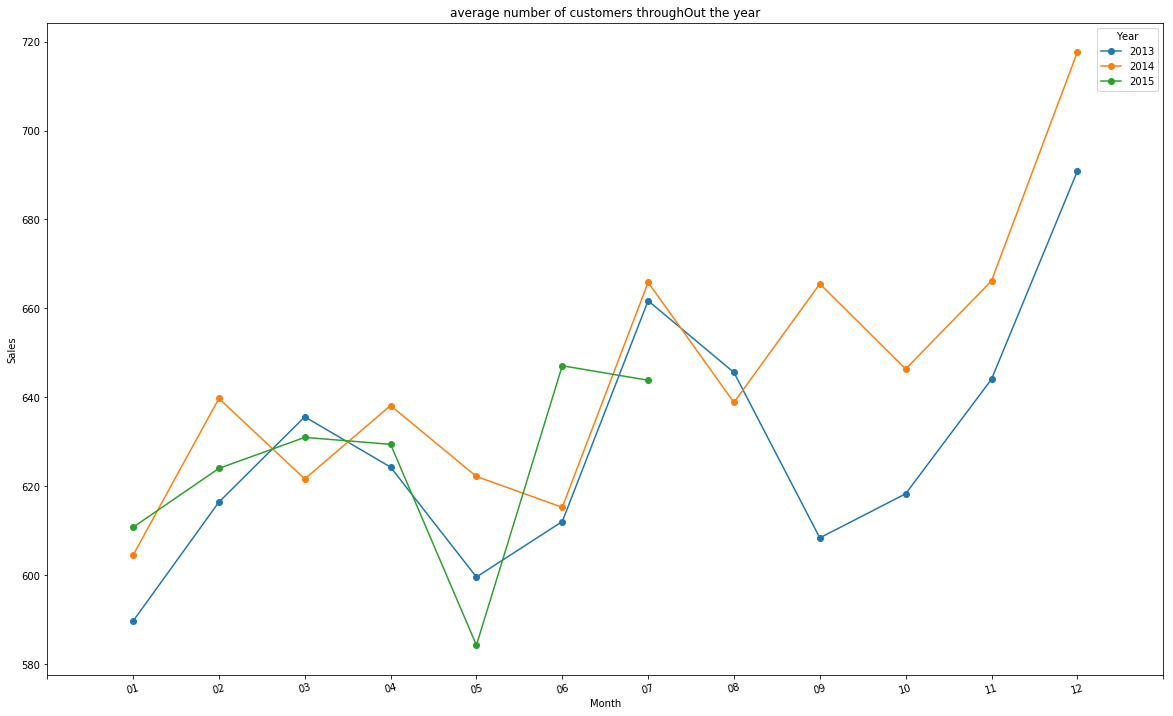

In [15]:
overAllMonthlyCustomers = df_train.groupby(['Month','Year'])["Customers"].mean()
seriesPlots(overAllMonthlyCustomers.unstack(),'average number of customers throughOut the year')

Plotting sales and customers on the same graph to highlight the fact they  are correlated features

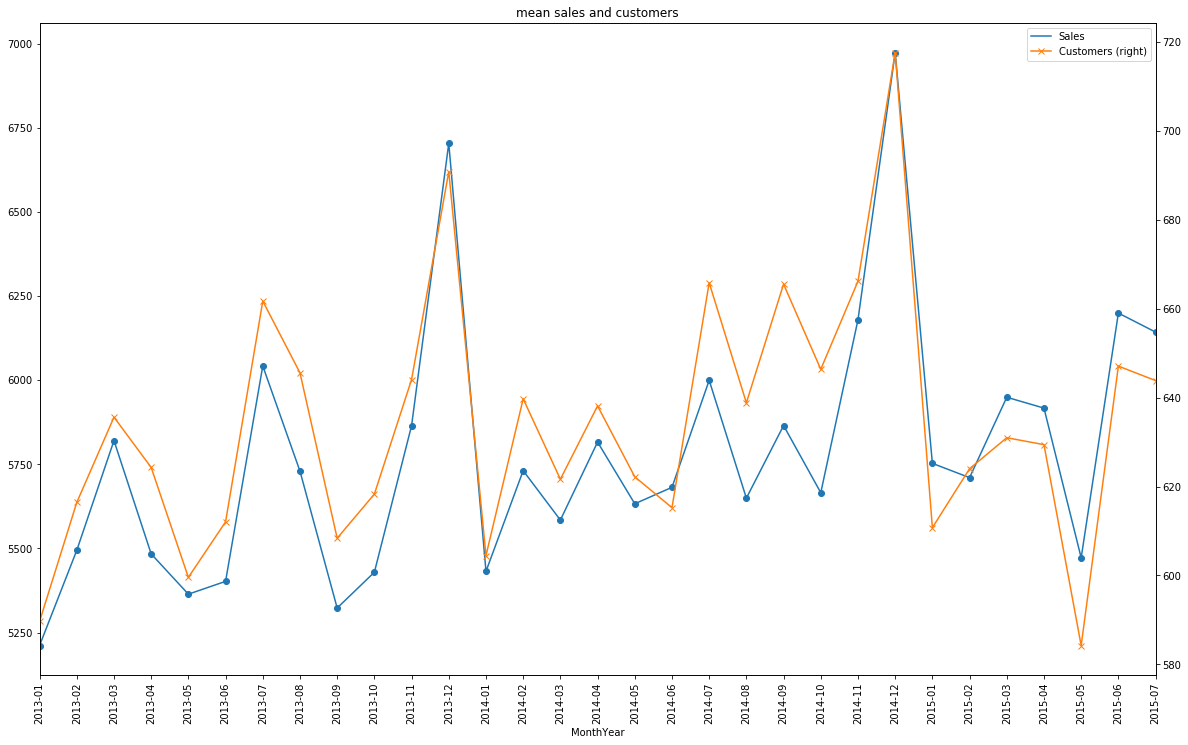

In [16]:
##this
plt.figure()
axis = plt.gca()
overAllMonthlySales = df_train.groupby(['MonthYear'])["Sales"].mean()
ax1 = overAllMonthlySales.plot(legend=True, ax=axis, marker='o', figsize=(20, 12), title='mean sales and customers')
ax1.set_xticks(range(len(overAllMonthlySales)))
ax1.set_xticklabels(overAllMonthlySales.index.tolist(),rotation = 90)
# plot pct change
overAllMonthlyCustomers = df_train.groupby(['MonthYear'])["Customers"].mean()
ax2 = overAllMonthlyCustomers.plot(legend=True, ax=axis,rot = 90, marker='x',secondary_y=True)

### inter store relations
let us see what happens to customers and sales on every store

In [18]:
sales_perstore = df_train.groupby('Store')["Sales"].mean()
cust_perstore = df_train.groupby('Store')["Customers"].mean()
store_ids = list(np.unique(df_train['Store']))

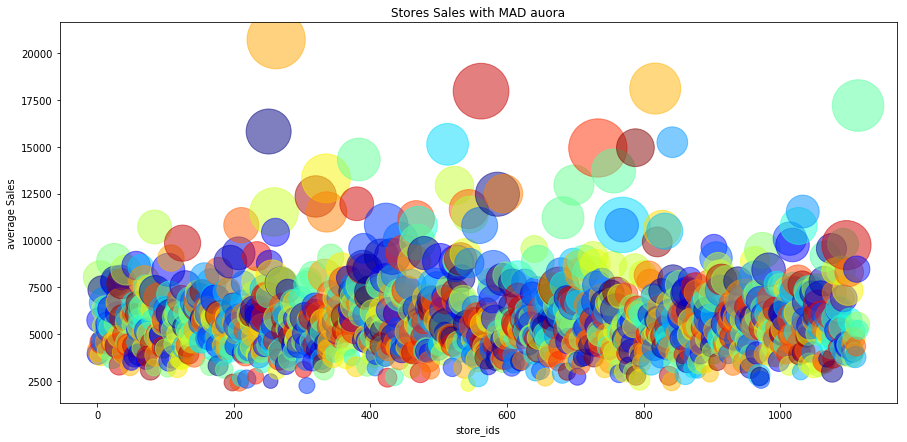

In [19]:
fig, (axis1) = plt.subplots(1,1, sharex=True,figsize=(15,7))
colors = np.random.rand(len(sales_perstore))
axis1.scatter(store_ids, sales_perstore.values, s=cust_perstore.values, c=colors, cmap='jet', alpha=0.5)
axis1.set_xlabel('store_ids')
axis1.set_ylabel('average Sales')
axis1.set_title('Stores Sales with MAD auora')

The patterns in the above graph are all over the place. this was expected. What it tells is that each store is doing very much alike other stores.

### number of customer and sales
The number of customers and sales are strongly correlated even on a store-wise basis. Just like on a given date, if any store gets more customers, it has more sales. A polynomial line is drawn in thsi graph just to emphasise this fact. 

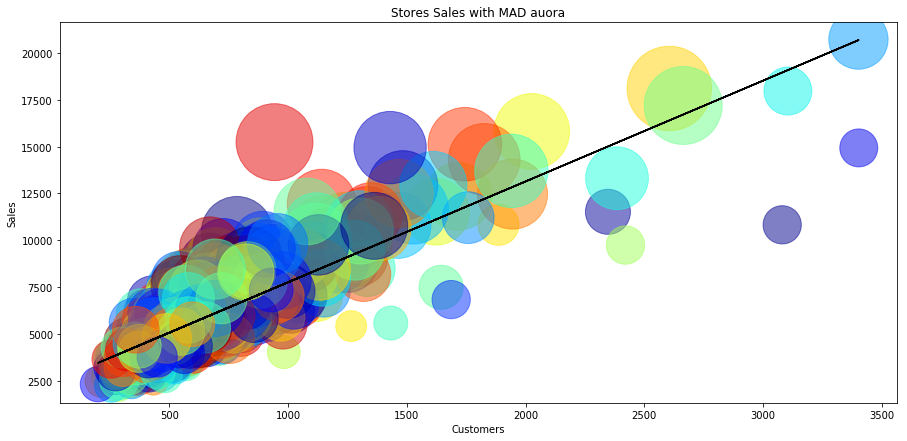

In [21]:

####realte from above with customer graphs
sales_perstore = df_train.groupby('Store')['Sales'].mean()
mad_sales_perstore = df_train.groupby('Store')['Sales'].mad()
cust_perstore = df_train.groupby('Store')["Customers"].mean()
mad_cust_perstore = df_train.groupby('Store')['Customers'].mad()
# sales to customer ratio
sales_cust_ratio = sales_perstore/cust_perstore
mad_sales_cust_ratio = mad_sales_perstore/cust_perstore  # MAD for sales_cust_ratio is ratio between MAD sales and total customers
# plot scatter plot of sales vs customers
fig, (axis1) = plt.subplots(1,1, sharex=True,figsize=(15,7))
colors = np.random.rand(len(sales_perstore))
axis1.scatter(cust_perstore, sales_perstore, s=mad_sales_perstore, c=colors, cmap='jet', alpha=0.5)
axis1.set_xlabel('Customers')
axis1.set_ylabel('Sales')
axis1.set_title('Stores Sales with MAD auora')
# plot a fitted line
linefit = np.poly1d(np.polyfit(cust_perstore, sales_perstore, 1))(cust_perstore);
axis1.plot(cust_perstore, linefit, color = 'k')

We actually cannot have customers as a feature but the high correlation means that in general any feature that contrasts with customers will contrast the same with sales the same. Such a feature is useful to fill NAs or Impute data. Below is the value of correlation.

In [22]:
stats.pearsonr(df_train.Customers, df_train.Sales)[0]

0.8947107733017011

### Promo
The stores seem to be successful to increase their sales when a promotion is going on. but later we will see that the affect is pretty small on a daily basis 

Average sale when there is NO promotion:  4406.050805160786
Average sale when there is A promotion:  7991.152045969903


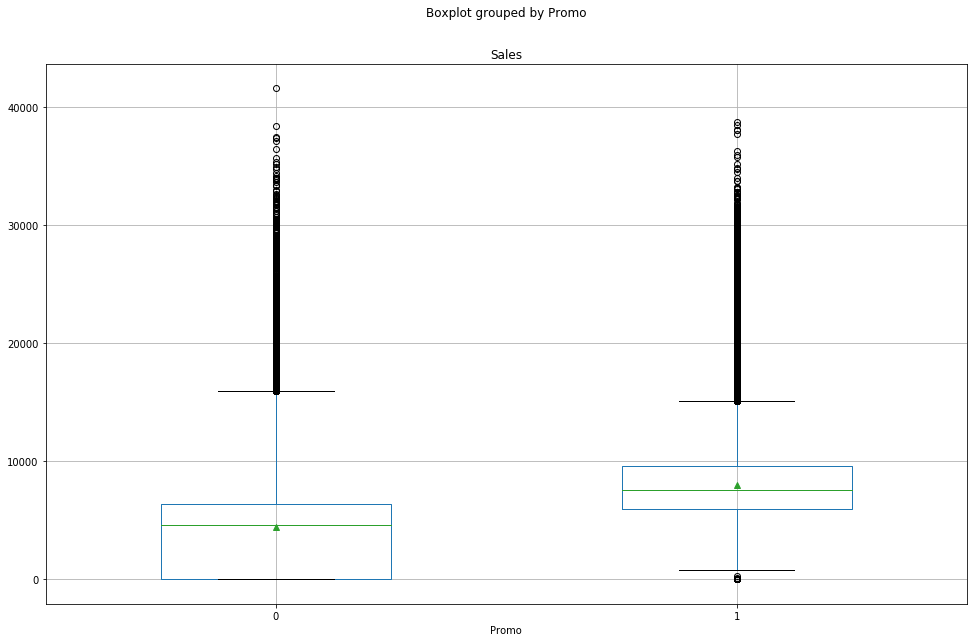

In [23]:
valuesOfMeans = df_train.groupby(['Promo'])["Sales"].mean()
print('Average sale when there is NO promotion: ',valuesOfMeans.values[0])
print('Average sale when there is A promotion: ',valuesOfMeans.values[1])
df_train.boxplot(by='Promo',column='Sales',figsize=(16,10),widths=0.5,showbox=True,showcaps=True,showfliers=True,showmeans=True)

The boxplot shows a stark imporvement in sales when the store is having a promotion scheme running. Lets check this out on a per store basis.

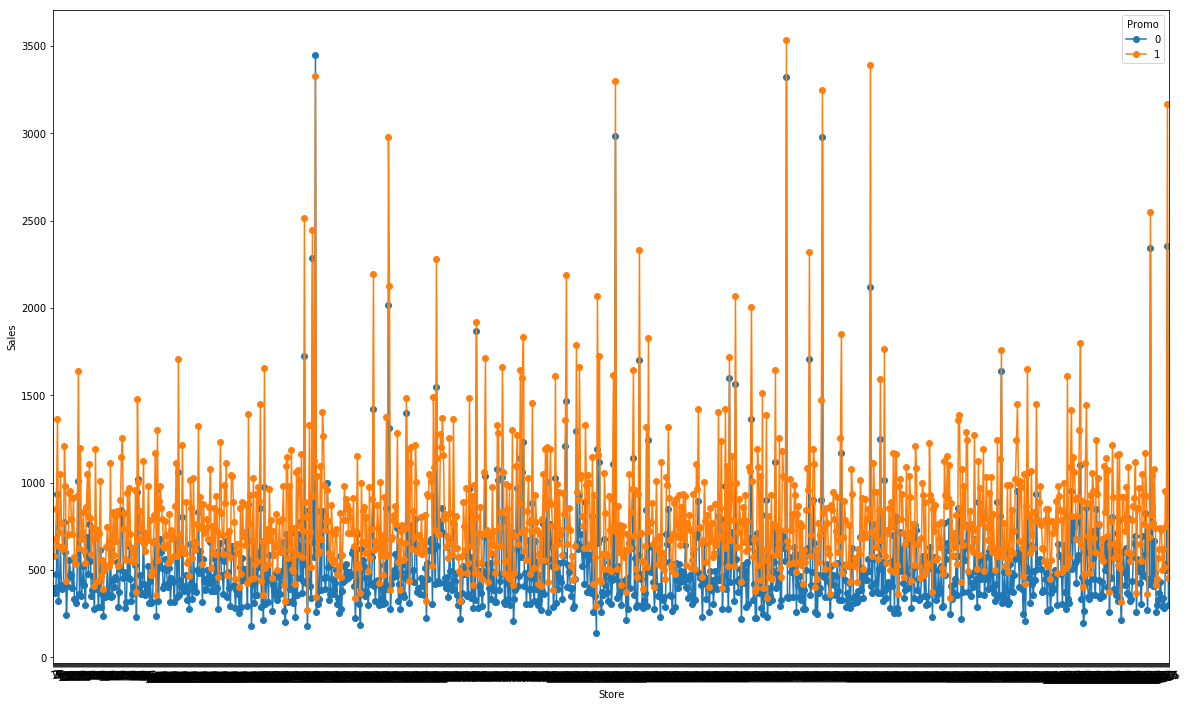

In [24]:
storeWiseMonthlyCustomersPromo = df_train.groupby(['Store','Promo'])["Customers"].mean()
seriesPlots(storeWiseMonthlyCustomersPromo.unstack())

It is evident that having promotion on any gvien day brings mroe customer and sales to the store.

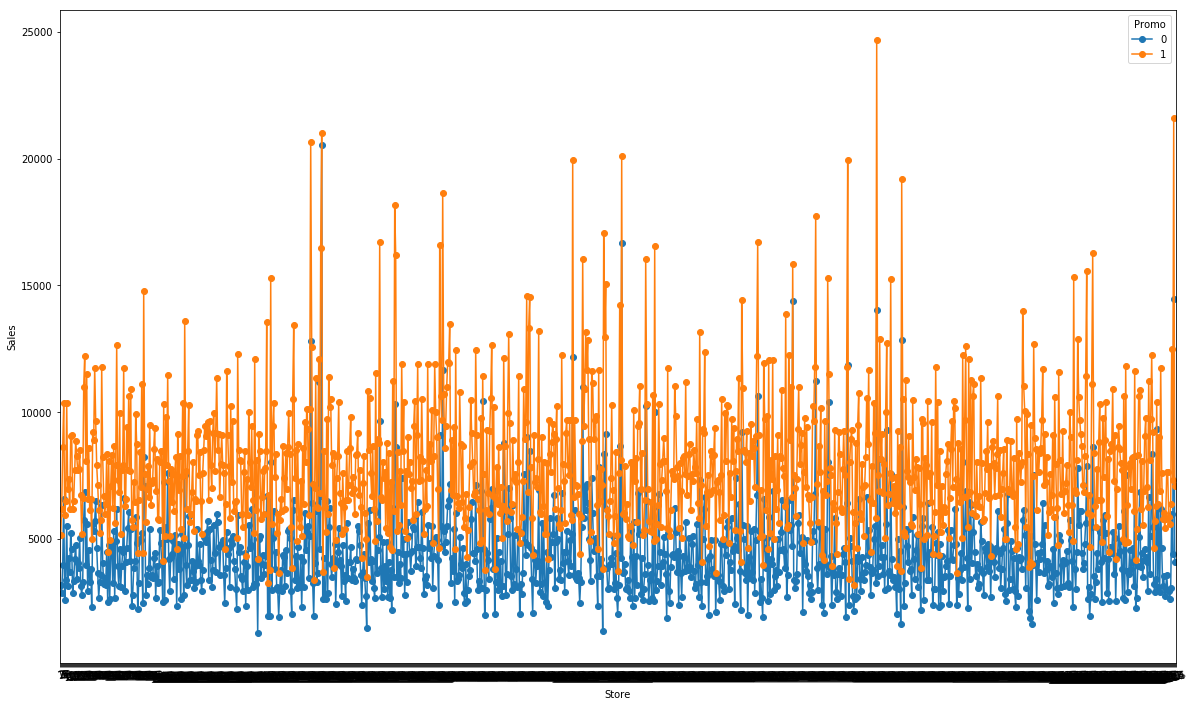

In [25]:
overAllMonthlySalesPromo = df_train.groupby(['Store','Promo'])["Sales"].mean()
seriesPlots(overAllMonthlySalesPromo.unstack())

### affect of StateHoliday, SchoolHoliday and Promotion 
here we are interested what other factors change the sales. so far we have not been able to govern what makes the 'business months' better than others for business. let us calculate some aggregates over the data.

In [27]:
mean_sales = df_train.groupby('MonthYear')['Sales'].mean()
pct_mean_change = df_train.groupby('MonthYear')['Sales'].mean().pct_change()
# median customers
mean_cust = df_train.groupby('MonthYear')['Customers'].mean()
pct_mean_custchange = df_train.groupby('MonthYear')['Customers'].mean().pct_change()

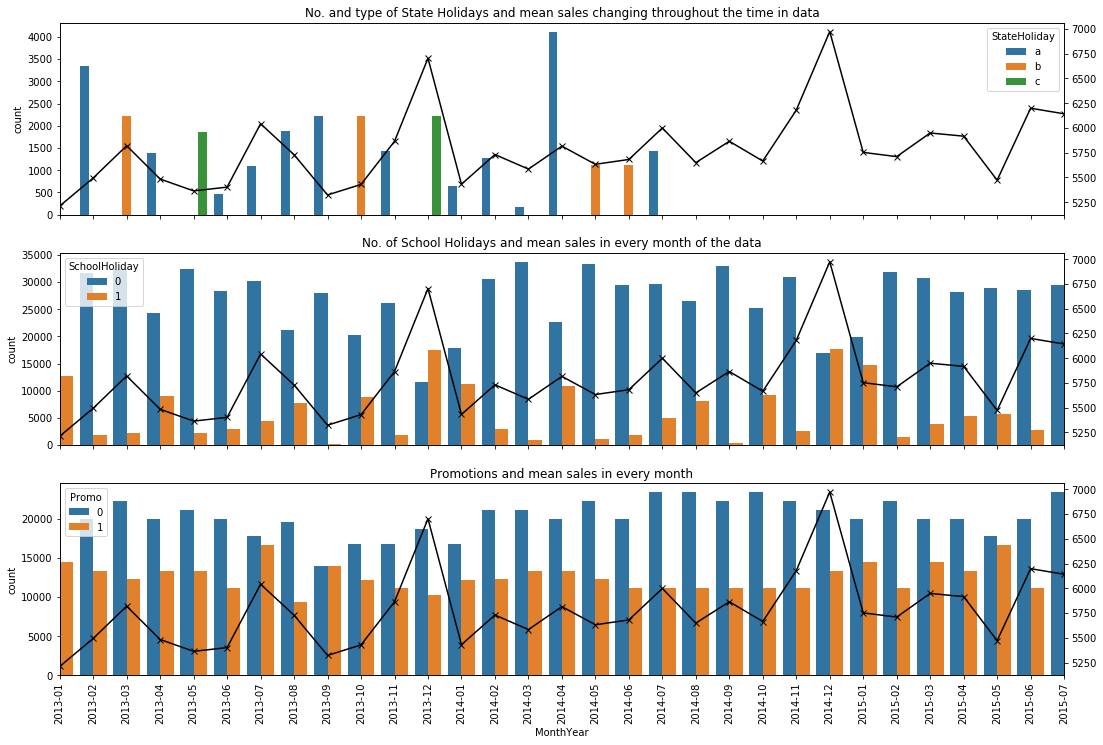

In [29]:
fig, (ax) = plt.subplots(3, 1, sharex=True, figsize=(18,12)) # axis1, axis2, 
ax[0] = sns.countplot(x='MonthYear', hue='StateHoliday', data=df_train[df_train['StateHoliday']!='O'], ax=ax[0])
tmp = ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
mean_sales.plot(ax=ax[0], marker='x', secondary_y=True,color= 'k')
tmp = ax[0].set_title('No. and type of State Holidays and mean sales changing throughout the time in data')
#schoolholiday overlay
ax[1] = sns.countplot(x='MonthYear', hue='SchoolHoliday', data=df_train, ax=ax[1])
mean_sales.plot(ax=ax[1], marker='x', secondary_y=True,color= 'k')
tmp = ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
tmp = ax[1].set_title('No. of School Holidays and mean sales in every month of the data')
#promotions overlay
#ax5 = sns.countplot(x='MonthYear', hue='Promo', data=df_train[df_train["Promo"]!=0], palette='husl', ax=axis5)
ax[2] = sns.countplot(x='MonthYear', hue='Promo', data=df_train, ax=ax[2])
#subs = train[train['Promo']!=0]
#cntchange = subs.groupby('MonthYear')['Promo'].count().pct_change()
#cntchange.plot(ax=axis5, marker='x', secondary_y=True)
mean_sales.plot(ax=ax[2], marker='x', secondary_y=True,color= 'k')
tmp = ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
tmp = ax[2].set_title('Promotions and mean sales in every month')

#remark how consecutive two months of holidays affect more, but the affect is more prominent due to easter christmas season

### insight
There are two many values of 'promo' variable to see a clear effect. but it seems when ever the school holidays in consecutive two months are high, the sales decline. that is true around the end of the year period and in the mid summer season. 

In [30]:
###storing competition starting date for every store
def competitionOpeningDate(dataRow):
    if(not(np.isnan(dataRow['CompetitionOpenSinceMonth']))): #& not(np.isnan(dataRow['CompetitionOpenSinceYear']))):
        if(not(np.isnan(dataRow['CompetitionOpenSinceYear']))):
            return datetime.datetime(year=int(dataRow['CompetitionOpenSinceYear']), month=int(dataRow['CompetitionOpenSinceMonth']), day=1)
        else:
            return ''
    else:
        return ''

df_store['competitionOpeningFinalDate']= df_store.apply(lambda x: competitionOpeningDate(x) , axis = 1)

In [31]:
#bring data of store to look at its affect on sales
df_combined = df_train.merge(df_store, how='left', on='Store')

### affect of assortment on sales
lets see how different assortments of stores affect sales

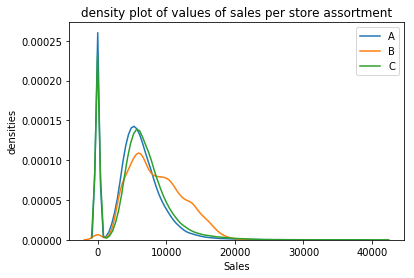

In [32]:
#assortment
sns.distplot(df_combined[df_combined['Assortment'] == 'a']['Sales'],label='A', hist=False)
sns.distplot(df_combined[df_combined['Assortment'] == 'b']['Sales'],label='B', hist=False)
sns.distplot(df_combined[df_combined['Assortment'] == 'c']['Sales'],label='C', hist=False)

plt.xlabel('Sales')
plt.ylabel('densities')
plt.title('density plot of values of sales per store assortment')
plt.legend()
plt.show()

The assortment type 'b' seems to perform differently than others

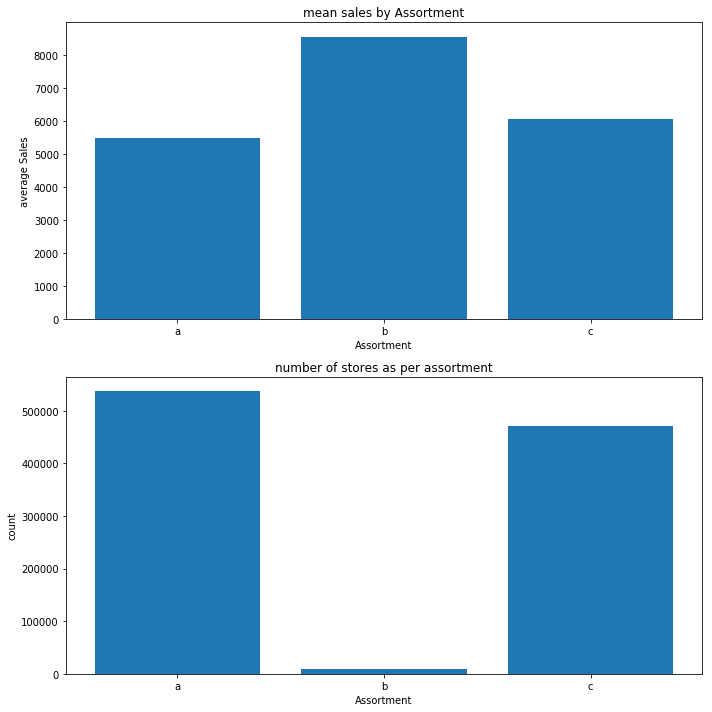

In [33]:
unique_types = len(np.unique(df_combined['Assortment'])) 
x = range(unique_types)
xLabels = list(df_combined.groupby(by="Assortment").sum().Sales.index)

fig, axes = plt.subplots(2, 1,figsize=(10,10))
y = df_combined.groupby("Assortment").Sales.mean()
axes[0].bar(x,y)
axes[0].set_ylabel("average Sales")  
axes[0].set_xlabel("Assortment")  
axes[0].set_xticks(x)
axes[0].set_xticklabels(xLabels)
axes[0].set_title("mean sales by Assortment")

y = df_combined.groupby("Assortment").Sales.count()
axes[1].bar(x,y.values)
axes[1].set_ylabel("count")  
axes[1].set_xlabel("Assortment")  
axes[1].set_xticks(x)
axes[1].set_xticklabels(xLabels)
axes[1].set_title("number of stores as per assortment")

fig.tight_layout()

plt.show()


### insight
even the stores with assortment 'b' are too few in the data but they outperform other assortment types. We can make a new category for such data. much the same can be said about storeTypes

### Affect of storeType
In the same way we can plot sales and bservations for different storTypes in the data.

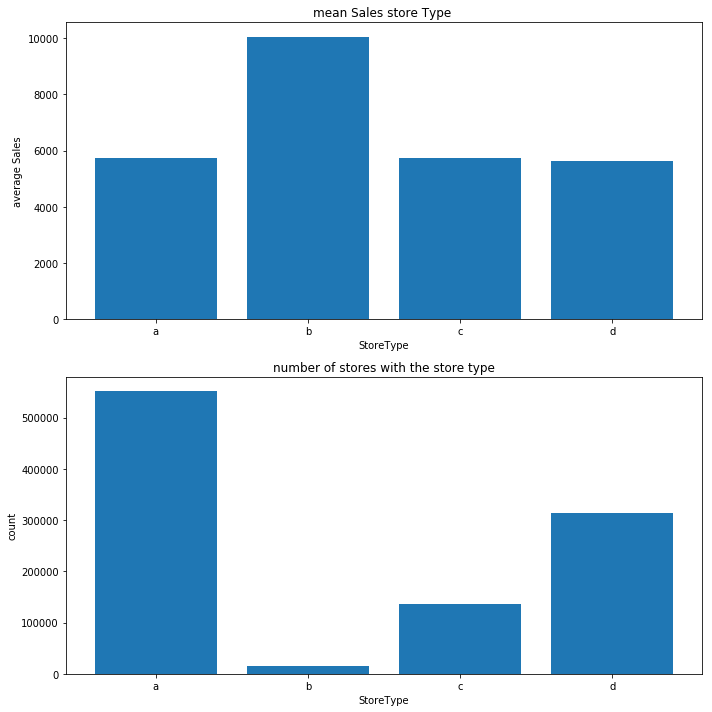

In [34]:
unique_types = len(np.unique(df_combined['StoreType'])) 
x = range(unique_types)
xLabels = list(df_combined.groupby(by="StoreType").sum().Sales.index)

fig, axes = plt.subplots(2, 1,figsize=(10,10))
y = df_combined.groupby("StoreType").Sales.mean()
axes[0].bar(x,y)
axes[0].set_ylabel("average Sales")  
axes[0].set_xlabel("StoreType")  
axes[0].set_xticks(x)
axes[0].set_xticklabels(xLabels)
axes[0].set_title("mean Sales store Type ")

y = df_combined.groupby("StoreType").Sales.count()
axes[1].bar(x,y.values)
axes[1].set_ylabel("count")  
axes[1].set_xlabel("StoreType")  
axes[1].set_xticks(x)
axes[1].set_xticklabels(xLabels)
axes[1].set_title("number of stores with the store type")

fig.tight_layout()
plt.show()


In [35]:
##Basically this function tells if there is a second promotion going on a given date 
def promo2Worker(dataRow):
    if dataRow['Promo2'] == 0:
        return 'No' # No promo2
    currentWeek = datetime.datetime.strptime(str(dataRow['Date']),'%Y-%m-%d').strftime('%W')
    currentYear = datetime.datetime.strptime(str(dataRow['Date']),'%Y-%m-%d').strftime('%Y')
    currentMonthStr =  datetime.datetime.strptime(str(dataRow['Date']),'%Y-%m-%d').strftime('%b')
    if ((float(currentWeek) >= dataRow['Promo2SinceWeek']) & (float(currentYear) >= dataRow['Promo2SinceYear'])):
        if (currentMonthStr in dataRow['PromoInterval']):
            return 'Yes'
        else: 
            return 'No'
    else:
        return 'Yes'


In [36]:
#comment on NA problem
df_combined['isItPromo2'] = df_combined.apply(lambda x: promo2Worker(x) , axis = 1)

In [ ]:
#df_combined.to_csv('latest_check2.csv')

### affect of promo2
unlike the first promotion scheme, the second promotion scheme does not seem to do any affect on sales.

Average sale when there is NO promotion:  5962.7135330558085
Average sale when there is A promotion:  5428.576132099074


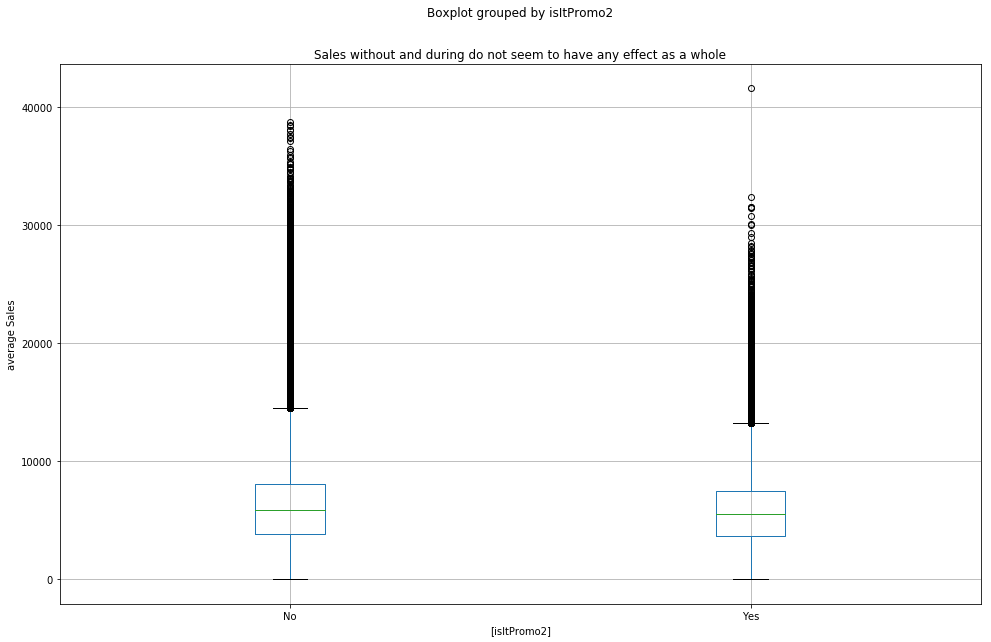

In [37]:
valuesOfMeans = df_combined.groupby(['isItPromo2'])["Sales"].mean()
print('Average sale when there is NO promotion: ',valuesOfMeans.values[0])
print('Average sale when there is A promotion: ',valuesOfMeans.values[1])
ax = df_combined.boxplot(column='Sales',by=['isItPromo2'],figsize=(16,10))
ax.set_ylabel("average Sales")
ax.set_title('Sales without and during do not seem to have any effect as a whole')

### affect of the presence of a compeition
first we would have to found out the dates for which there is a competition. I made a function for that earlier.

In [38]:
df_combined['Date_dateTime'] = df_combined['Date'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d'))

In [39]:
df_withCompetitionDates = df_combined[df_combined['competitionOpeningFinalDate'].notnull()]
#ownFeatures['losses'] = ownFeatures.apply((lambda x: -1*x['sales'] if x['cOrder'] else 0) , axis = 1)  #and losses of whole data and see
df_withCompetitionDates['IsCompetitionNow'] =df_withCompetitionDates.apply((lambda x: 'Yes' if x['Date_dateTime'] >= x['competitionOpeningFinalDate'] else 'No'),axis=1)

c:\users\gebruiker\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


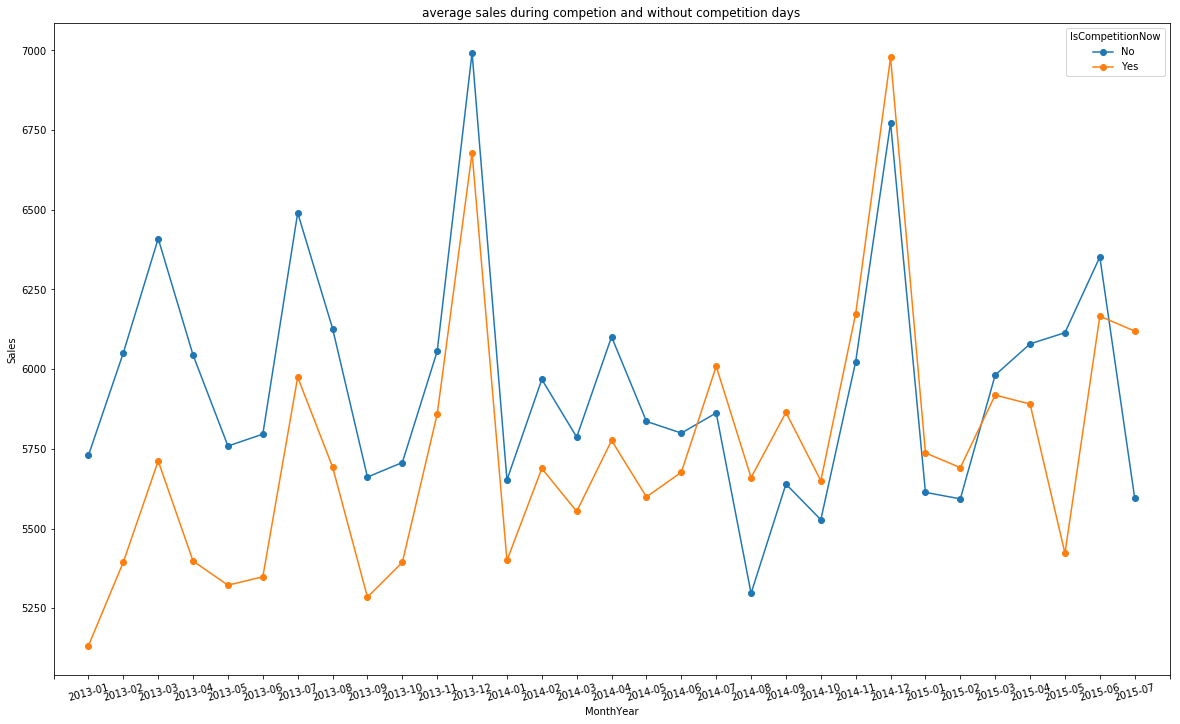

In [37]:
##just a time series plot. seems like the competition might be better judged on store basis
performanceDueToCompetion = df_withCompetitionDates.groupby(['MonthYear','IsCompetitionNow'])["Sales"].mean()
seriesPlots(performanceDueToCompetion.unstack(),'average sales during competion and without competition days')

there is not much to asses form such overall plots. A small range of sales values around the competiton starting dates will be a good way to look at the effect. 

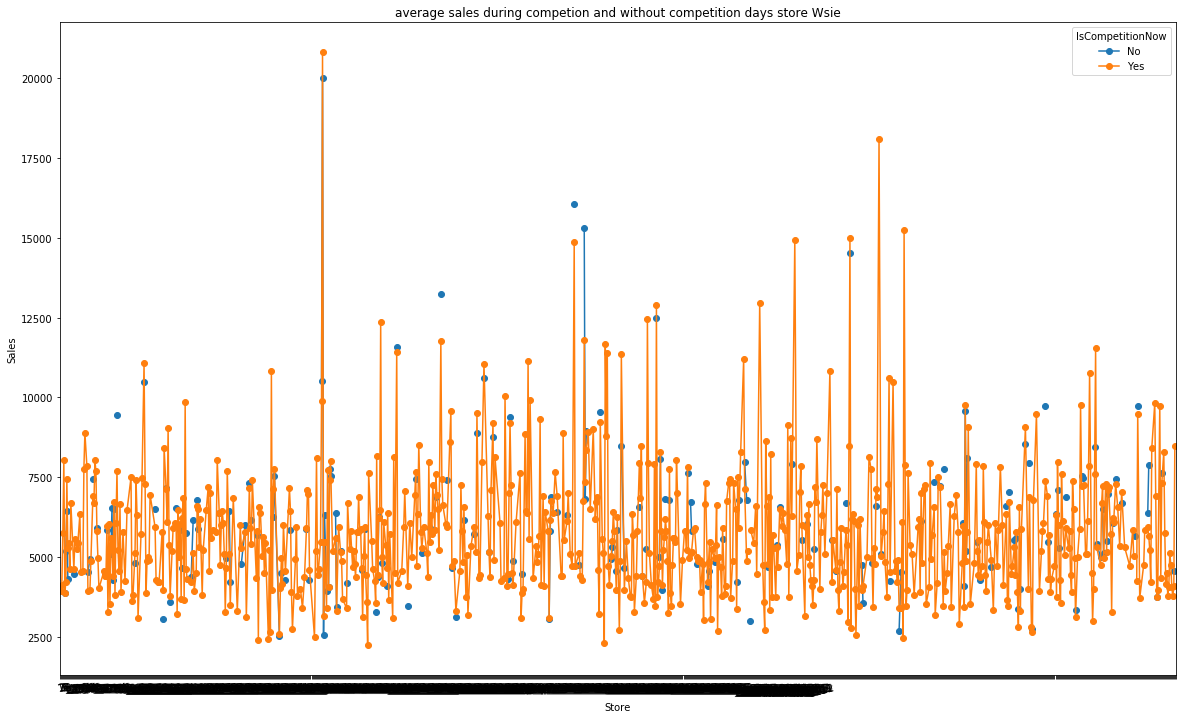

In [41]:

performanceDueToCompetionStoreWise = df_withCompetitionDates.groupby(['Store','IsCompetitionNow'])["Sales"].mean()
seriesPlots(performanceDueToCompetionStoreWise.unstack(),'average sales during competion and without competition days store Wsie')

### insight
I did not implement the buffering and looking at the competition starting points. It is because the effect around the competition starting point does not follow a patter over all sotres or days. Let us look at compare each store before and after the sales one more time.

In [43]:
numberOfDaysUnderCompetition = df_withCompetitionDates.groupby(['Store','IsCompetitionNow'])['Date'].count()
salesOfStoresUnderCompetition = df_withCompetitionDates.groupby(['Store','IsCompetitionNow'])["Sales"].mean()
salesOfStoresUnderCompetition = salesOfStoresUnderCompetition.unstack()
numberOfDaysUnderCompetition = numberOfDaysUnderCompetition.unstack()

You immediately get to know that most of the stroes are facing a competition. Also the relation between before and after sales of any store is repeated over many stores. once again, every store is behaving pretty much like other stores

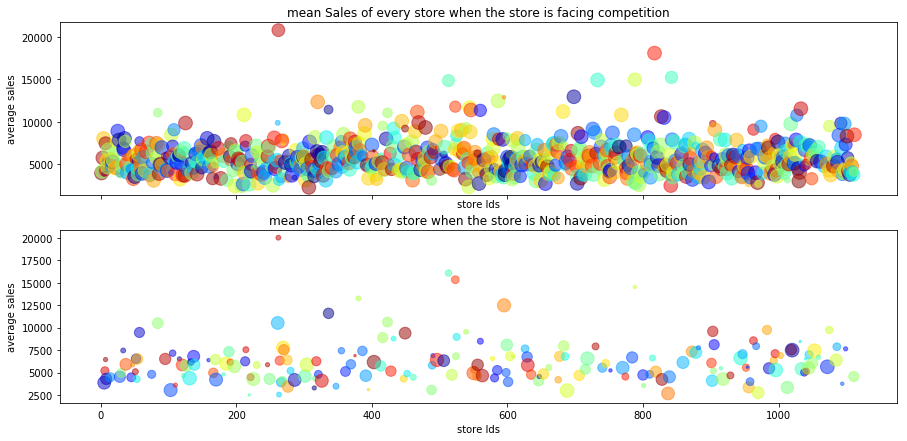

In [44]:
competitionOpenDays = numberOfDaysUnderCompetition['Yes']
competitionClosedDays = numberOfDaysUnderCompetition['No']

compOpenSales = salesOfStoresUnderCompetition['Yes']
compClosedSales = salesOfStoresUnderCompetition['No']

stores_list = list(np.unique( df_withCompetitionDates['Store']))
# plot scatter plot of sales vs customers
fig, (axis) = plt.subplots(2,1, sharex=True,figsize=(15,7))
colors = np.random.rand(len(stores_list))
axis[0].scatter(stores_list, compOpenSales, s=(competitionOpenDays/5), c=colors, cmap='jet', alpha=0.5,)
axis[0].set_xlabel('store Ids')
axis[0].set_ylabel('average sales')
axis[0].set_title("mean Sales of every store when the store is facing competition")

axis[1].scatter(stores_list, compClosedSales, s=(competitionClosedDays/5), c=colors, cmap='jet', alpha=0.5)
axis[1].set_xlabel('store Ids')
axis[1].set_ylabel('average sales')
axis[1].set_title("mean Sales of every store when the store is Not haveing competition")



### affect of Competition distance
this is a categorical variable. let us start by creating a spread of its values

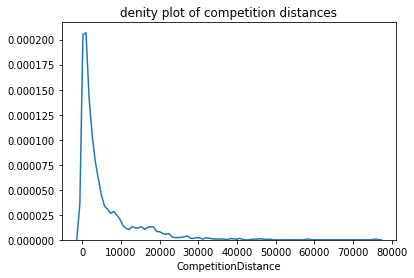

In [45]:
ax = sns.distplot(df_combined[df_combined['CompetitionDistance'].notnull()]['CompetitionDistance'], hist=False)
ax.set_title('denity plot of competition distances')
plt.show()

Using pandas cut to create and find effect of the competition distance values on sales 

c:\users\gebruiker\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


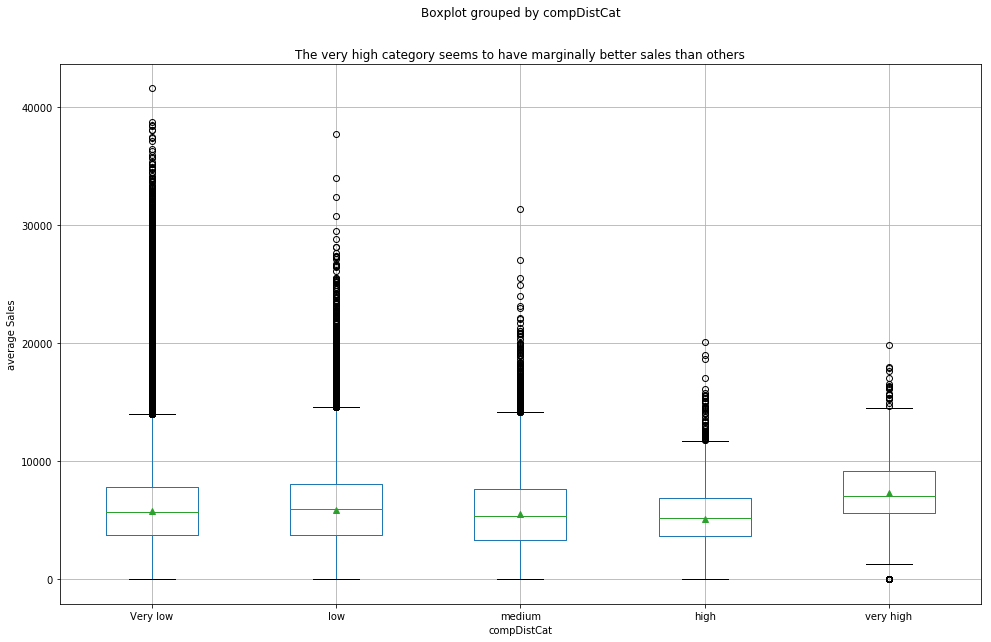

In [46]:
sub_comptData = df_combined[df_combined['CompetitionDistance'].notnull()]
sub_comptData['compDistCat'] = pd.cut(sub_comptData['CompetitionDistance'],5, labels=["Very low",'low', "medium",'high', "very high"])
ax = sub_comptData.boxplot(by='compDistCat',column='Sales',figsize=(16,10),widths=0.5,showbox=True,showcaps=True,showfliers=True,showmeans=True)
ax.set_ylabel("average Sales")
ax.set_title('The very high category seems to have marginally better sales than others')

It seems the categories over customer distances have an affect on the sales. There is another way to make groups from the continous values. Maybe that will give us a better seperation amongst the data along competition distance values

c:\users\gebruiker\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


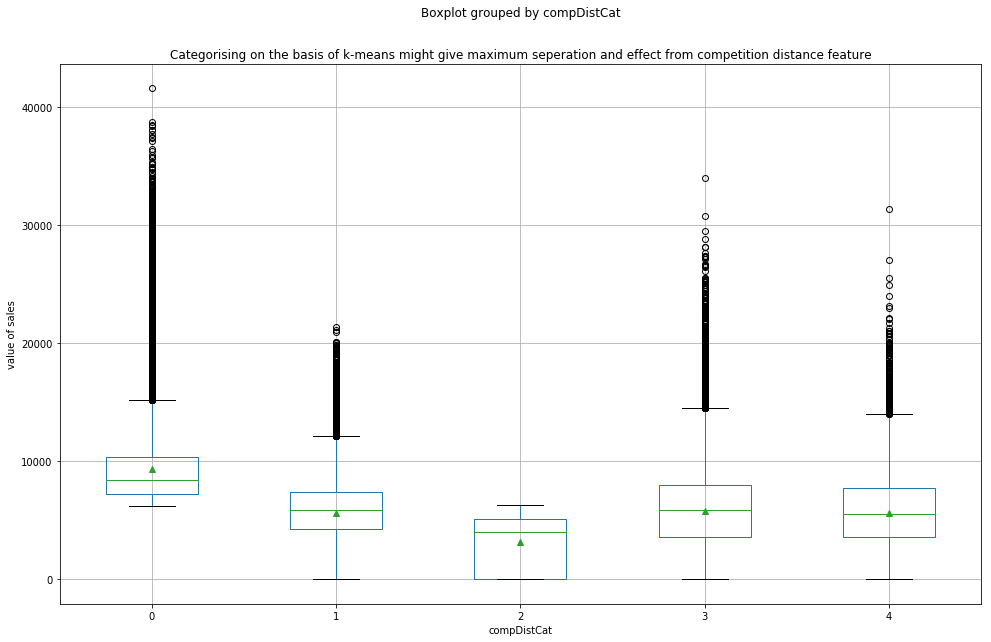

In [47]:
sub_comptData = df_combined[df_combined['CompetitionDistance'].notnull()]
from sklearn import cluster
k_means = cluster.KMeans(n_clusters=5)
#sub_comptData = sub_comptData[sub_comptData['salesPerCustomer'].notnull()]
model = k_means.fit(sub_comptData[['CompetitionDistance','Sales']]) 
sub_comptData['compDistCat'] = model.labels_
ax = sub_comptData.boxplot(by='compDistCat',column='Sales',figsize=(16,10),widths=0.5,showbox=True,showcaps=True,showfliers=True,showmeans=True)
ax.set_ylabel('value of sales')

ax.set_title('Categorising on the basis of k-means might give maximum seperation and effect from competition distance feature')

The grouping above seems to be more powerful and the distance does seem to have affect. One needs to write the means and expressions of these clusters otherwise this 'compDistCat' feature will keep on changing. lets see the values of distance in these groups and their effect on customers and sales to understand

In [48]:
effectOfDistOnCustomers = sub_comptData[sub_comptData['Open'] != 0].groupby(['compDistCat'])['Customers'].mean()
effectOfDistOnSales = sub_comptData[sub_comptData['Open'] != 0].groupby(['compDistCat'])["Sales"].mean()
effectOfDistAggregated = pd.concat([effectOfDistOnSales, effectOfDistOnCustomers], axis=1).reset_index()

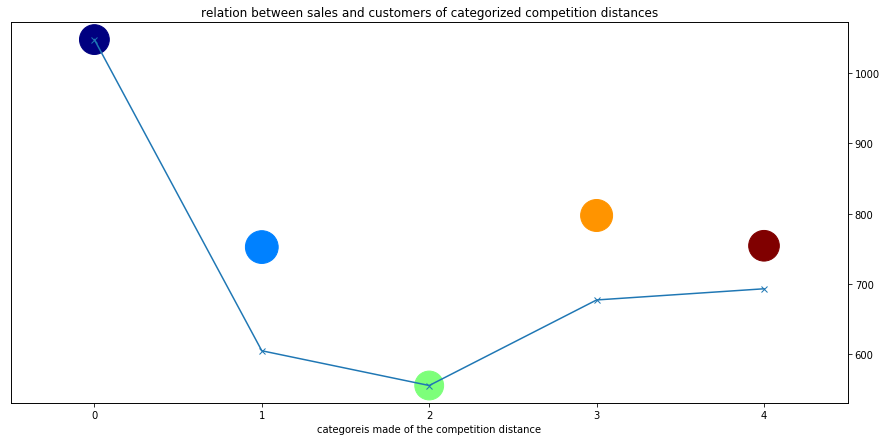

In [60]:
y_kmeans = model.predict(sub_comptData[['CompetitionDistance','Sales']])

x_list = list(effectOfDistAggregated['compDistCat'])
x_list = np.arange(len(x_list))
#dot_sizes = temp['Sales'] / temp['Customers']#change to sales Per Customer or total sales
dot_sizes = effectOfDistAggregated['Sales']/effectOfDistAggregated['Customers']
colors = np.unique(y_kmeans)
fig, (axis1) = plt.subplots(1,1, sharex=True,figsize=(15,7))
axis1.scatter(x_list, effectOfDistAggregated['Sales'], s=(dot_sizes * 100), c=colors, cmap='jet')
axis1.set_xlabel('categoreis made of the competition distance')
axis1.set_ylabel('average Sales in every category')
axis1.set_title('relation between sales and customers of categorized competition distances')
effectOfDistAggregated['Customers'].plot(ax=axis1, marker='x', secondary_y=True)
plt.xlim(min(x_list)-0.5,max(x_list) + 0.5);


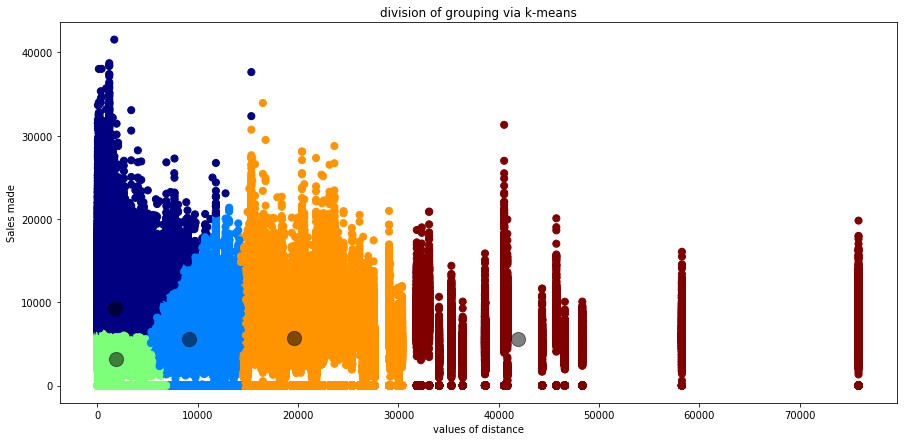

In [61]:
#ax = sns.distplot(df_combined[df_combined['CompetitionDistance'].notnull()]['CompetitionDistance'], hist=False)
#ax.set_title('denity plot of competition distances')
#centers = k_means.cluster_centers_
#ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
#plt.show()
#y_kmeans = model.predict(sub_comptData[['CompetitionDistance','Sales']])
fig, (axis1) = plt.subplots(1,1, sharex=True,figsize=(15,7))
axis1.scatter(sub_comptData[['CompetitionDistance']],sub_comptData[['Sales']], c=y_kmeans, s=50, cmap='jet')
centers = k_means.cluster_centers_
axis1.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
axis1.set_xlabel('values of distance')
axis1.set_ylabel('Sales made')
axis1.set_title('division of grouping via k-means')
plt.show()


### insight
While the stores that have less competition are frqeuntly visited, the trend is not conclusive. some stores who are far from competition alos get lots more customer then some of the stores that have a competition near to them. I have not taken this category feature but the continous variable instead.

In [62]:
#df_withCompetitionDates = df_combined[df_combined['competitionOpeningFinalDate'].notnull()]
#ownFeatures['losses'] = ownFeatures.apply((lambda x: -1*x['sales'] if x['cOrder'] else 0) , axis = 1)  #and losses of whole data and see
df_combined['IsCompetitionNow'] =df_combined.apply((lambda x: 'Yes' if x['Date_dateTime'] >= x['competitionOpeningFinalDate'] else 'No'),axis=1)

In [63]:
def lumpAssortmentStoreType(dataRow):
    if  (dataRow['Assortment'] == 'b')  | (dataRow['StoreType'] == 'b'):
        return 'yes'
    else :
        return 'no'
df_combined['assortment_storeType'] =df_combined.apply((lambda x: lumpAssortmentStoreType(x)),axis=1)

#### puttin assortment and storeType together
the representation of this data is small in the data set but the effect is strong.

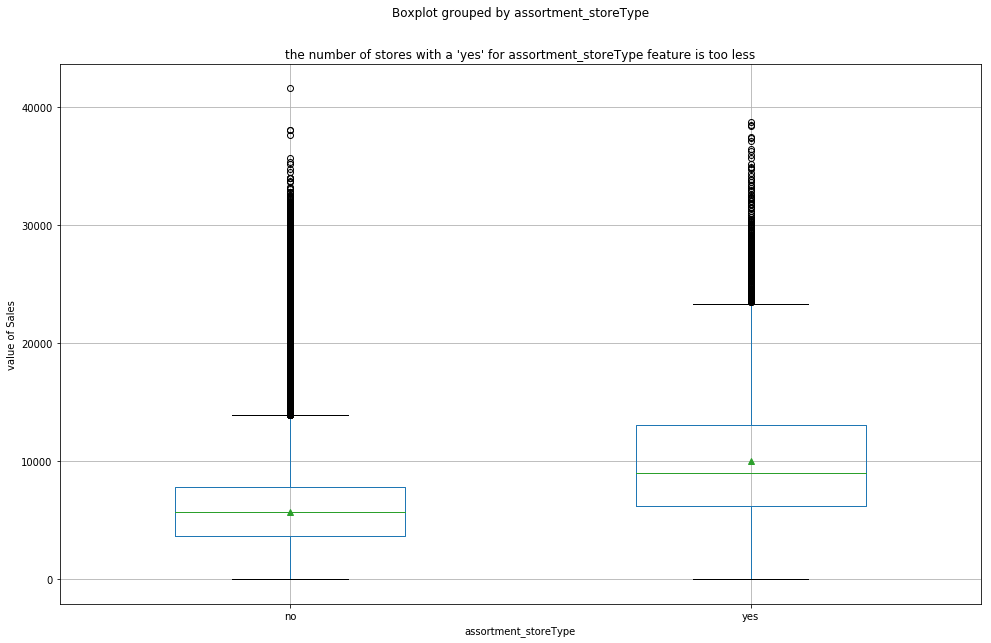

In [65]:
ax = df_combined.boxplot(by='assortment_storeType',column='Sales',figsize=(16,10),widths=0.5,showbox=True,showcaps=True,showfliers=True,showmeans=True)
ax.set_ylabel("value of Sales")
ax.set_title('the number of stores with a \'yes\' for assortment_storeType feature is too less')

## Final Remark EDA:
After observing the data, following observations were recorded: <br>
Slaes differences among stores is still not concretely determined as most of the features are not realted strongly to sales <br>
The stores are operating in a competitive market and those who do not have are not generally better performers <br>
Sales per year have a lot of similarity to their previosu values. As it is a time series, a moving average(differences) or frequency based prediction will be quite good at prediction, thug it will not tell much about the business insight. <br>
More customers mean more sales and the promotion scheme seem to encourage customers marginally <br>
Most of the competition to stores is from a time before the data starts. The comparison between before and after sales is very short lived and stores tend to function normally with or without competition <br>
SchoolHolidays perhaps match the best with the timing of the high perfoming months in the dataset <br>

After observing the data, following features are selected: <br>
SchoolHoliday: as the number of schoolHolidays on a given month have a trend appering between them and monthly sales  <br>
Promo: more sales when the stores are running promotion <br>
IsItCompetitionNow: Most stores are facing a competition. but this variable forms a timeseries of its own for each store. <br>
Open: the sales are zero if the store is not open. THis variable can remove data quality issues and errors <br>
dayOfWeek: the sales in days of week vary <br>
assortment_storeType: the affect of the storetype and assortment anomaly. Maybe it is better if I remove such data altogether. <br>
CompetitionDistance: as a continous variable.<br>